# 介绍

* [python时间序列ARIMA的实现及原理（预测茅台股票数据）](https://blog.csdn.net/qq_36523839/article/details/80191243)
* [Python中做时间序列分析](https://www.ichdata.com/use-python-to-do-time-series.html)
* [Python 3中使用ARIMA进行时间序列预测的指南](https://blog.csdn.net/u014096903/article/details/79980036)
* [ Python 主要时序模式算法—StatsModels库](https://www.jianshu.com/p/62787f89b382)

差分一般做1、2阶便可以了，原因在于差分其实是对信息提取加工的过程，每次差分都会带来信息损失，过度差分会导致有效信息损失而降低精度。一般情况下，线性变化通过 1 次差分即可平稳，非线性趋势 2，3 次差分也能变得平稳，一般差分次数不超过 2 次。而且数据处理也比较粗糙，只是一个浅显的思路，仅作基础的入门参考，后续将会做更完善的文章介绍。

# Show Me The Codes

In [52]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tushare as ts
from dateutil.parser import parse
import seaborn as sns
sns.set_style("whitegrid",{"font.sans-serif":['KaiTi', 'Arial']})

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline


In [35]:
# k  = ts.get_hist_data('600519') #600519茅台股票  这里可以设置获取的时间段
k  = ts.get_hist_data('600519',)

In [41]:
k.index

Index(['2019-06-06', '2019-06-05', '2019-06-04', '2019-06-03', '2019-05-31',
       '2019-05-30', '2019-05-29', '2019-05-28', '2019-05-27', '2019-05-24',
       ...
       '2016-12-19', '2016-12-16', '2016-12-15', '2016-12-14', '2016-12-13',
       '2016-12-12', '2016-12-09', '2016-12-08', '2016-12-07', '2016-12-06'],
      dtype='object', name='date', length=609)

/root/tools/anaconda3/envs/flux/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/root/tools/anaconda3/envs/flux/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


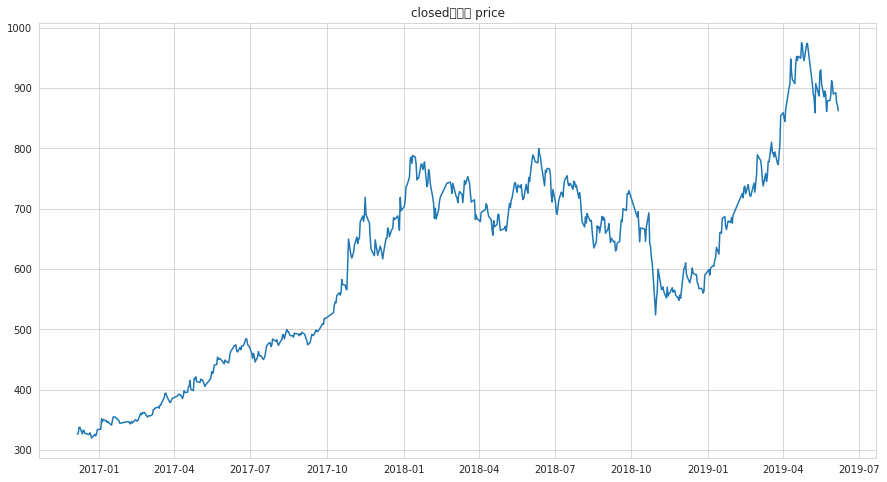

In [53]:
lit = ['open', 'high', 'close', 'low']  #这里我们只获取其中四列
data = k[lit]

d_one = data.index      #以下9行将object的index转换为datetime类型
d_two = []
d_three = []
date2 = []
for i in d_one:
    d_two.append(i)

for i in range(len(d_two)):
    d_three.append(parse(d_two[i]))

#构建新的DataFrame赋予index为转换的d_three。当然你也可以使用date_range()来生成时间index
data2 = pd.DataFrame(data,index=d_three,dtype=np.float64)   

plt.figure(figsize=(15, 8))
plt.plot(data2['close'])    #一看数据就不稳定，所以我们需要做差分
plt.title('closed price')
plt.show()

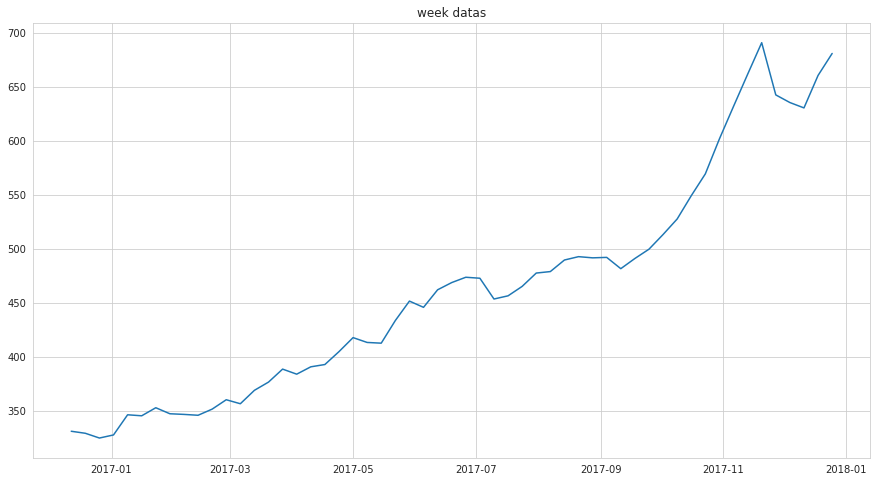

In [47]:
data2_w = data2['close'].resample('W-MON').mean()   #由于原始数据太多，按照每一周来采样，更好预测，并取每一周的均值

data2_train = data2_w['2015':'2017']    #我们只取2015到2017的数据来训练

plt.figure(figsize=(15, 8))
plt.plot(data2_train)
plt.title('week datas')
plt.show()

/root/tools/anaconda3/envs/flux/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 1080x576 with 0 Axes>

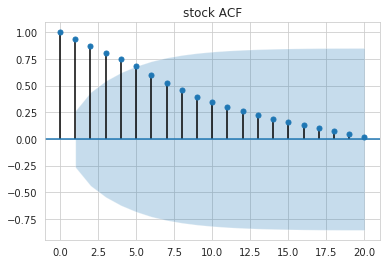

In [18]:
 #一阶差分，分析ACF
acf = plot_acf(data2_train, lags=20)     #通过plot_acf来查看训练数据，以便我们判断q的取值

plt.title("stock ACF")
acf.show()

/root/tools/anaconda3/envs/flux/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


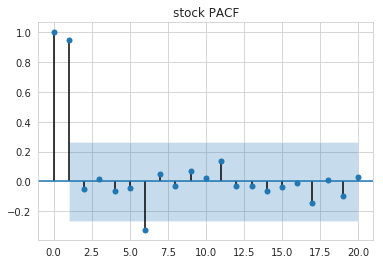

In [19]:
 #一阶差分，分析PACF
pacf = plot_pacf(data2_train,lags=20)   #通过plot_pacf来查看训练数据，以便我们判断p的取值
plt.title("stock PACF")
pacf.show()

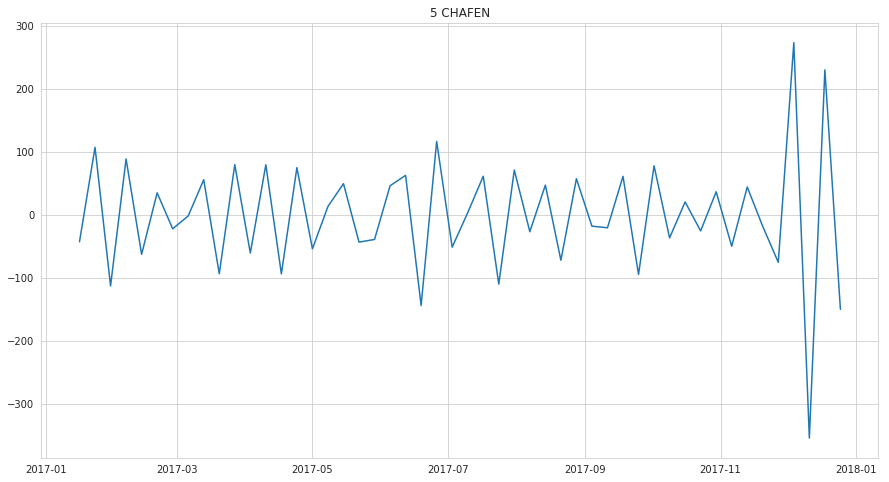

In [49]:
#处理数据，平稳化处理
data2_diff = data2_train.diff(1)    #差分很简单使用pandas的diff()函数可以进行一阶差分
diff = data2_diff.dropna()
for i in range(4):          #五阶差分，一般一到二阶就行了，我有点过分
    diff = diff.diff(1)
    diff = diff.dropna()

plt.figure(figsize=(15, 8))
plt.plot(diff)
plt.title('5 CHAFEN')
plt.show()

/root/tools/anaconda3/envs/flux/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


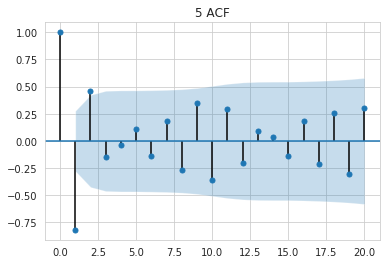

In [23]:
# 五阶差分的ACF
acf_diff = plot_acf(diff,lags=20)
plt.title("5 ACF")         #根据ACF图，观察来判断q
acf_diff.show()

/root/tools/anaconda3/envs/flux/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


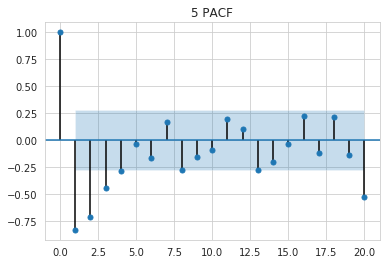

In [50]:
# 五阶差分的PACF
pacf_diff = plot_pacf(diff,lags=20)   #根据PACF图，观察来判断p
plt.title("5 PACF")
pacf_diff.show()

In [26]:
#根据ACF和PACF以及差分 定阶并建模
model = ARIMA(data2_train, order=(6,1,5), freq='W-MON')   #pdq    频率按周

#拟合模型
arima_result = model.fit()

#预测
pred_vals = arima_result.predict('2017-01-02',dynamic=True,typ='levels')    #输入预测参数，这里我们预测2017-01-02以后的数据

#可视化预测
stock_forcast = pd.concat([data2_w,pred_vals],axis=1,keys=['original', 'predicted'])   #将原始数据和预测数据相结合，使用keys来分层


LinAlgError: SVD did not converge

In [27]:
#构图
plt.figure()
plt.plot(stock_forcast)
plt.title('真实值vs预测值')
plt.show()

NameError: name 'stock_forcast' is not defined

<Figure size 432x288 with 0 Axes>